In [2]:
import os
import xml.etree.ElementTree as ET
from natsort import natsorted
import pandas as pd
from PIL import Image
import numpy as np
import requests
from zipfile import ZipFile
from io import BytesIO
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import random
from six.moves import xrange
import collections
import string

In [3]:

def download_dataset(save_path):
    r = requests.get("http://cimalab.unal.edu.co/applications/thyroid/thyroid.zip")
    print("Downloading...")
    z = ZipFile(BytesIO(r.content))
    z.extractall(save_path)
    print("Completed...")

# XML and Jpeg
def to_dataframe(path):
    dirs=natsorted(os.listdir(path))
    xml_list=[]
    img_list=[]
    for i in range(len(dirs)):
        if '.xml' in dirs[i]:
            xml_list.append(dirs[i])
        if not '.xml'  in dirs[i]:
            img_list.append(dirs[i])
    xml_list=natsorted(xml_list)
    img_list=natsorted(img_list)
    tirads=[]
    for j in range(len(xml_list)):
        tree = ET.parse(path+'/'+xml_list[j])
        a=tree.findall("./tirads")
        if a[-1].text!=None:
            case=[xml_list[j],a[-1].text]
            tirads.append(case)
    data=[]
    for k in range(len(tirads)):
        xml=tirads[k][0][:-4]
        for z in range(len(img_list)):
            if xml+'_1.jpg'==img_list[z] or xml+'_2.jpg'==img_list[z] or xml+'_3.jpg'==img_list[z]:
                m=[img_list[z],tirads[k][1]]
                data.append(m)

    df = pd.DataFrame(data,columns =['Jpeg_Name', 'Tirads'])
    return df

#Cropp Function
def croping(img,x, y, w, h):
    if abs(w)<abs(h):
        img2=np.zeros([h,h])
        img2[:,h-w:h]=img[y:y+h, x:x+w]
    if abs(h)<abs(w):
        img2=np.zeros([w,w])
        img2[w-h:w,:]=img[y:y+h, x:x+w]
    else:
        return img
    return img2

def convert_one_channel(img):
    #if some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img

#Remove Fill area from Image and Resizeing
def crop_resize(path,resize_shape):
    img=plt.imread(path)
    img=convert_one_channel(np.asarray(img))
    kernel =( np.ones((5,5), dtype=np.float32))
    ret,thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
    thresh = thresh.astype(np.uint8)
    a1,b1=thresh.shape
    thresh=cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel,iterations=3 )
    thresh=cv2.erode(thresh,kernel,iterations =5)
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    c_area=np.zeros([len(contours)])
    for i in range(len(contours)):
        c_area[i]= cv2.contourArea(contours[i])
    cnts=contours[np.argmax(c_area)]
    x, y, w, h = cv2.boundingRect(cnts)
    roi = croping(img, x, y, w, h)
    roi=cv2.resize(roi,(resize_shape),interpolation=cv2.INTER_LANCZOS4)
    return roi


# TO Data Matrix
def to_imgmatrix(resize_shape,path,df):
    path=path+'/'
    images=crop_resize(path+df["Jpeg_Name"][0],resize_shape)
    for i in range (1,len(df["Jpeg_Name"])):
        img=crop_resize(path+df["Jpeg_Name"][i],resize_shape)
        images=np.concatenate((images,img))
    images=np.reshape(images,(len(df["Jpeg_Name"]),resize_shape[0],resize_shape[1],1))
    return images

def prepare_data(path,resize_shape):
    df=to_dataframe(path)
    data=to_imgmatrix(resize_shape,path,df)
    return df,data


# We need numeric category
def to_categoricalmatrix(df):
    #There are little categories, so i handled manually
    Y=np.zeros([len(df["Tirads"])])
    for i in range(len(df["Tirads"])):
        if df["Tirads"][i]=="2":
          Y[i]=0
        if df["Tirads"][i]=="3":
          Y[i]=1
        if df["Tirads"][i]=="4a":
          Y[i]=2
        if df["Tirads"][i]=="4b":
          Y[i]=3
        if df["Tirads"][i]=="4c":
          Y[i]=4
        if df["Tirads"][i]=="5":
          Y[i]=5
    return Y


In [4]:
download_dataset("/content/Data")

Downloading...
Completed...


In [5]:
df,data=prepare_data("/content/Data",(256,256))

In [6]:
df.head()

,Jpeg_Name,Tirads
0,2_1.jpg,2
1,3_1.jpg,4a
2,4_1.jpg,4a
3,5_1.jpg,5
4,6_1.jpg,4b


In [7]:
y = to_categoricalmatrix(df)

y = tf.keras.utils.to_categorical(y)


In [8]:
#normalize function
def normalize(data):
  for i in range(len(data)):
    data[i,:,:,:]=data[i,:,:,:]*(1/np.max(data[i,:,:,:]))
  return np.float32(data)

# we need noormalize to images
x=normalize(data)

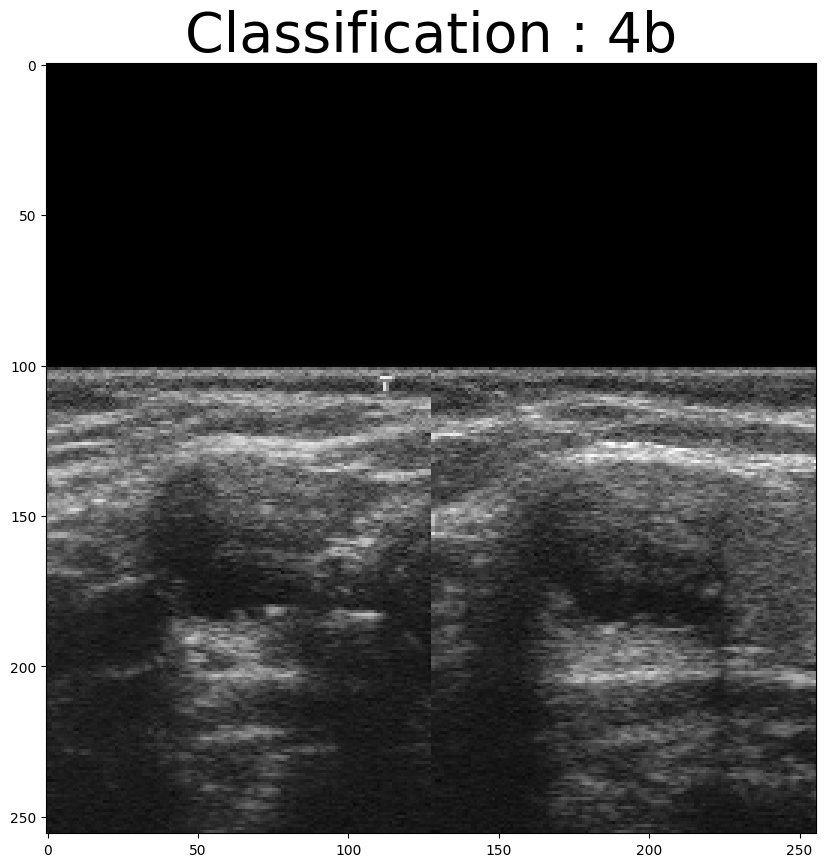

In [9]:
random_number2=random. randint(0,len(df["Tirads"]))
plt.figure(figsize = (20,10))
tit2 = "Classification : " + str(df["Tirads"][random_number2])
plt.title(tit2,fontsize = 40)
plt.imshow(x[random_number2,:,:,0],cmap="gray")

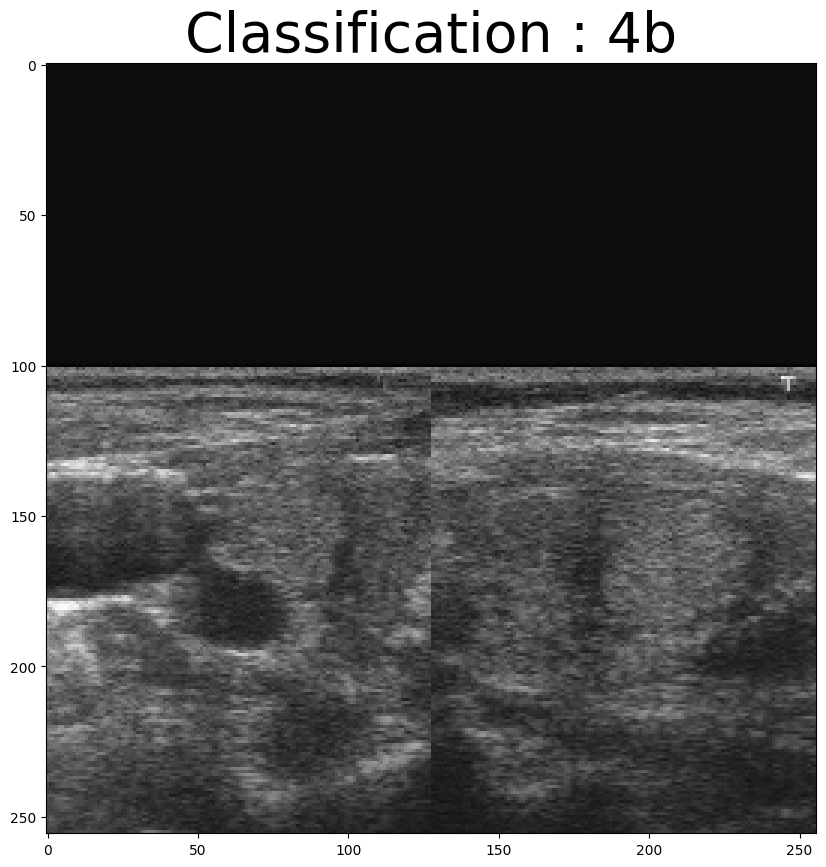

In [10]:
import random
random_number=random. randint(0,len(df["Tirads"]))
plt.figure(figsize = (20,10))
tit2 = "Classification : " + str(df["Tirads"][random_number2])
plt.title(tit2,fontsize = 40)
plt.imshow(x[random_number,:,:,0],cmap="gray")

In [11]:
#Splitting test and train
x_train=np.copy(x[:300,:,:,:])
x_test=np.copy(x[313:,:,:,:])
x_valid=np.copy(x[300:313,:,:,:])

y_train=np.copy(y[:300,:])
y_valid=np.copy(y[300:313,:])
y_test=np.copy(y[313:,:])

In [12]:
from tensorflow.keras import layers
#Data Augmention for to prevent Overfitting and to improve accuracy
data_augmentation1 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), fill_mode="constant"),
    tf.keras.layers.RandomRotation(factor=(-0.2, 0.2), fill_mode="constant"),
    tf.keras.layers.RandomContrast(0.1)
])


x_train1=data_augmentation1(x_train)
y_train1=np.copy(y_train)
i=1

#22
while(i<22):
  x_aug=data_augmentation1(x)
  x_train1=np.concatenate((x_train1,x_aug),axis=0)
  y_aug=np.copy(y)
  y_train1=np.concatenate((y_train1,y_aug))

  #20
  if i == 20:
    break
  i += 1

In [13]:
#Efficient Net Model based https://github.com/SerdarHelli/TensorflowWorks
CONV_KERNEL_INITIALIZER = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        'distribution': 'normal'
    }
}
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'strides', 'se_ratio'
])

BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)

DEFAULT_BLOCKS_ARGS = [
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=32, output_filters=16,
              expand_ratio=1, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=2, input_filters=16, output_filters=24,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=2, input_filters=24, output_filters=40,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=3, input_filters=40, output_filters=80,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=3, input_filters=80, output_filters=112,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(kernel_size=5, num_repeat=4, input_filters=112, output_filters=192,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(kernel_size=3, num_repeat=1, input_filters=192, output_filters=320,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25)
]

## Our MB_CONV_Block
def mb_conv_block(inputs,block_args,drop_rate):
  ##Mobile Inverted Residual block along with Squeeze  and Excitation block.
    kernel_size = block_args.kernel_size
    num_repeat= block_args.num_repeat
    input_filters= block_args.input_filters
    output_filters=block_args. output_filters
    expand_ratio= block_args.expand_ratio
    id_skip= block_args.id_skip
    strides= block_args.strides
    se_ratio= block_args.se_ratio
    # expansion phase
    expanded_filters = input_filters * expand_ratio
    x=tf.keras.layers.Conv2D(filters=expanded_filters, kernel_size=(1,1), padding="same",use_bias=False,kernel_initializer=CONV_KERNEL_INITIALIZER,)(inputs)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.activations.swish(x)
    # Depthwise convolution phase
    x_depth=tf.keras.layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same",strides=strides, use_bias=False,kernel_initializer=CONV_KERNEL_INITIALIZER,)(x)
    x=tf.keras.layers.BatchNormalization()(x_depth)
    x=tf.keras.activations.swish(x)
    #SE Block
    x =tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Reshape((1,1, expanded_filters ))(x)
    squeezed_filters = max (1, int(input_filters * se_ratio))
    x=tf.keras.layers.Conv2D(filters=squeezed_filters, kernel_size=(1,1),padding="same",kernel_initializer=CONV_KERNEL_INITIALIZER,)(x)
    x=tf.keras.activations.swish(x)
    x=tf.keras.layers.Conv2D(filters=expanded_filters, kernel_size=(1,1),padding="same",kernel_initializer=CONV_KERNEL_INITIALIZER,)(x)
    x=tf.keras.activations.sigmoid(x)
    x=tf.keras.layers.Multiply()([x_depth,x])
    #SE Block
    x=tf.keras.layers.Conv2D(filters=output_filters, kernel_size=(1,1),padding="same",use_bias=False,kernel_initializer=CONV_KERNEL_INITIALIZER,)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Dropout(drop_rate)(x)
    if id_skip and all( s == 1 for s in strides) and input_filters == output_filters:
      x=tf.keras.layers.Add()([inputs,x])
    return x

def round_filters(filters, width_coefficient, depth_divisor):
    """Round number of filters based on width multiplier."""
    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)


def round_repeats(repeats, depth_coefficient):
    """Round number of repeats based on depth multiplier."""
    return int(math.ceil(depth_coefficient * repeats))

def EfficientNet(width_coefficient,
                 depth_coefficient,
                 default_resolution,
                 dropout_rate=0.2,
                 drop_connect_rate=0.2,
                 depth_divisor=8,
                 model_name='efficientnet',
                 weights='imagenet',
                 input_shape=None,
                 blocks_args=DEFAULT_BLOCKS_ARGS,
                 **kwargs):


  #### Stem
  inputs = tf.keras.layers.Input(shape=(input_shape))
  x = tf.keras.layers.Conv2D(round_filters(32, width_coefficient, depth_divisor), 3,
                      strides=(2, 2),
                      padding='same',
                      use_bias=False,
                      name='stem_conv',kernel_initializer=CONV_KERNEL_INITIALIZER,)(inputs)
  x = tf.keras.layers.BatchNormalization( name='stem_bn')(x)
  x=tf.keras.activations.swish(x)
  num_blocks_total = sum(block_args.num_repeat for block_args in blocks_args)
  block_num = 0
  for idx, block_args in enumerate(blocks_args):
      assert block_args.num_repeat > 0
      # Update block input and output filters based on depth multiplier.
      block_args = block_args._replace(
          input_filters=round_filters(block_args.input_filters,
                                      width_coefficient, depth_divisor),
          output_filters=round_filters(block_args.output_filters,
                                        width_coefficient, depth_divisor),
          num_repeat=round_repeats(block_args.num_repeat, depth_coefficient))

      # The first block needs to take care of stride and filter size increase.
      drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
      x = mb_conv_block(x, block_args,
                        drop_rate=drop_rate)
      block_num += 1
      if block_args.num_repeat > 1:
          # pylint: disable=protected-access
          block_args = block_args._replace(
              input_filters=block_args.output_filters, strides=(1, 1))
          # pylint: enable=protected-access
          for bidx in xrange(block_args.num_repeat - 1):
              drop_rate = drop_connect_rate * float(block_num) / num_blocks_total
              block_prefix = 'block{}{}_'.format(
                  idx + 1,
                  string.ascii_lowercase[bidx + 1]
              )
              x = mb_conv_block(x, block_args,
                                drop_rate=drop_rate)
              block_num += 1
  x = tf.keras.layers.Conv2D(round_filters(1280, width_coefficient, depth_divisor), 1,
                      padding='same',
                      use_bias=False,
                      name='top_conv',kernel_initializer=CONV_KERNEL_INITIALIZER,)(x)
  x = tf.keras.layers.BatchNormalization(name='top_bn')(x)
  x=tf.keras.activations.swish(x)
  return tf.keras.Model(inputs, x, name=model_name)




def EfficientNetB0(
        input_tensor=None,
        input_shape=None,
        **kwargs
):
    return EfficientNet(
        1.0, 1.0, 224, 0.2,
        model_name='efficientnet-b0',
        input_tensor=input_tensor, input_shape=input_shape,
        **kwargs
    )


def EfficientNetB1(
        input_tensor=None,
        input_shape=None,
        **kwargs
        ):
    return EfficientNet(
        1.0, 1.1, 240, 0.2,
        model_name='efficientnet-b1',
        input_tensor=input_tensor, input_shape=input_shape,
        **kwargs
    )


def EfficientNetB2(
                   input_tensor=None,
                   input_shape=None,
                   **kwargs
                   ):
    return EfficientNet(
        1.1, 1.2, 260, 0.3,
        model_name='efficientnet-b2',
        input_tensor=input_tensor, input_shape=input_shape,
        **kwargs
    )


def EfficientNetB3(
                   input_tensor=None,
                   input_shape=None,**kwargs
                   ):
    return EfficientNet(
        1.2, 1.4, 300, 0.3,
        model_name='efficientnet-b3',
        input_tensor=input_tensor, input_shape=input_shape,
        **kwargs
    )


def EfficientNetB4(
        input_tensor=None,
        input_shape=None,
        **kwargs
        ):
    return EfficientNet(
        1.4, 1.8, 380, 0.4,
        model_name='efficientnet-b4',
        input_tensor=input_tensor, input_shape=input_shape,
        **kwargs
    )


def EfficientNetB5(
        input_tensor=None,
        input_shape=None,
        **kwargs
        ):
    return EfficientNet(
        1.6, 2.2, 456, 0.4,
        model_name='efficient3dnet-b5',
        input_tensor=input_tensor, input_shape=input_shape,
        **kwargs
    )

def EfficientNetB6(
        input_tensor=None,
        input_shape=None,
        **kwargs
        ):
    return EfficientNet(
        1.8, 2.6, 528, 0.5,
        model_name='efficientnet-b6',
        input_tensor=input_tensor, input_shape=input_shape,

        **kwargs
    )


def EfficientNetB7(
        input_tensor=None,
        input_shape=None,
        **kwargs
        ):
    return EfficientNet(
        2.0, 3.1, 600, 0.5,
        model_name='efficientnet-b7',
        input_tensor=input_tensor, input_shape=input_shape,
        **kwargs
    )

def EfficientNetL2(
        input_tensor=None,
        input_shape=None,
        **kwargs
        ):
    return EfficientNet(
        4.3, 5.3, 800, 0.5,
        model_name='efficientnet-l2',
        input_tensor=input_tensor, input_shape=input_shape,
        **kwargs
    )

In [14]:
def VGG19(input_shape,filters):
    inputs=tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(filters//16,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    x=tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(filters//16,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)



    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters//8,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(filters//8,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters//4,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv2D(filters//4,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters//4,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters//2,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Conv2D(filters//2,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters//2,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters,(3,3),activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(filters,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    last = tf.keras.layers.Conv2D(filters,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='top_conv')(x)

    model=tf.keras.Model(inputs,last,name="VGG19")
    return model



In [15]:
def check_balance(y):
  malign=0
  benign=0
  for i in range(len(y)):
    if y[i]<2:
      benign=benign+1
    else :
      malign=malign+1
  print("Maling Count :" , malign)
  print("Benign Count :" , benign)
  return malign,benign



In [16]:
base_model=VGG19(input_shape=(256,256,1),filters=512)
x = base_model.output
f=tf.keras.layers.Flatten(name="flatten")(x)
d2=tf.keras.layers.Dense(1024,activation="relu",kernel_regularizer=tf.keras.regularizers.l1_l2(0.00001))(f)
dp9=tf.keras.layers.Dropout(0.5)(d2)
d3=tf.keras.layers.Dense(1024,activation="relu")(f)
dp10=tf.keras.layers.Dropout(0.5)(d2)

final=tf.keras.layers.Dense(6,activation="softmax")(dp10)
model = tf.keras.Model( inputs =[ base_model.input], outputs = final)


In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 142,039,526 (541.84 MB)

 Trainable params: 142,036,774 (541.83 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [22]:
metrics=tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC',
    summation_method='interpolation'
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=[tf.keras.metrics.AUC(name='auc')])


def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 15
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lr_call = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
epochs=35
history=model.fit(x=[x_train1],y=[y_train1],batch_size=16,epochs=epochs,callbacks=[lr_call],validation_data=(x_valid,y_valid))

Epoch 1/35
453/453 ━━━━━━━━━━━━━━━━━━━━ 134s 220ms/step - auc: 0.5718 - loss: 9.2187 - val_auc: 0.3982 - val_loss: 5.3777 - learning_rate: 1.0000e-04
Epoch 2/35
453/453 ━━━━━━━━━━━━━━━━━━━━ 90s 164ms/step - auc: 0.6365 - loss: 4.7713 - val_auc: 0.3988 - val_loss: 4.7103 - learning_rate: 1.0000e-04
Epoch 3/35
453/453 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - auc: 0.6428 - loss: 4.0926 - val_auc: 0.4065 - val_loss: 3.8984 - learning_rate: 1.0000e-04
Epoch 4/35
453/453 ━━━━━━━━━━━━━━━━━━━━ 74s 163ms/step - auc: 0.6521 - loss: 3.5527 - val_auc: 0.3982 - val_loss: 3.7038 - learning_rate: 1.0000e-04
Epoch 5/35
453/453 ━━━━━━━━━━━━━━━━━━━━ 82s 163ms/step - auc: 0.6486 - loss: 3.1213 - val_auc: 0.3917 - val_loss: 3.7776 - learning_rate: 1.0000e-04
Epoch 6/35
453/453 ━━━━━━━━━━━━━━━━━━━━ 82s 163ms/step - auc: 0.6551 - loss: 2.8248 - val_auc: 0.3994 - val_loss: 3.1531 - learning_rate: 1.0000e-04
Epoch 7/35
453/453 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - auc: 0.6687 - loss: 2.5400 - val_auc: 0.4041 - v

In [23]:
from sklearn.metrics import confusion_matrix
predict=model.predict(x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


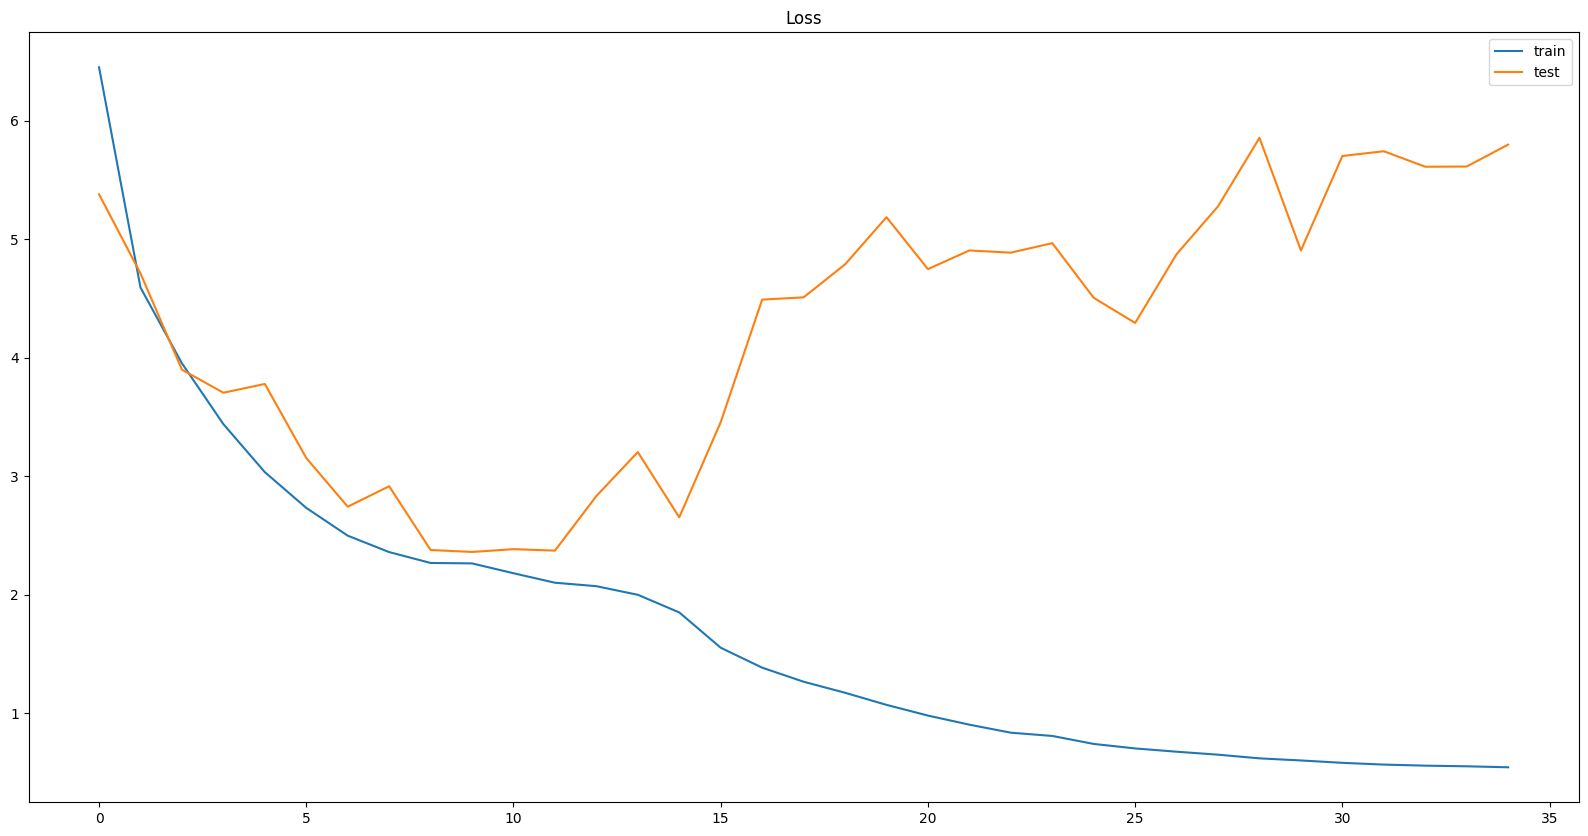

In [24]:
plt.figure(figsize = (20,10))
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [25]:
import sklearn
from sklearn.metrics import accuracy_score

auc = sklearn.metrics.roc_auc_score(y_test, predict)

In [26]:
y_test=np.reshape(y_test,(34*6))
predict=np.reshape(predict,(34*6))

No Skill: ROC AUC=0.500
Model: ROC AUC=0.718


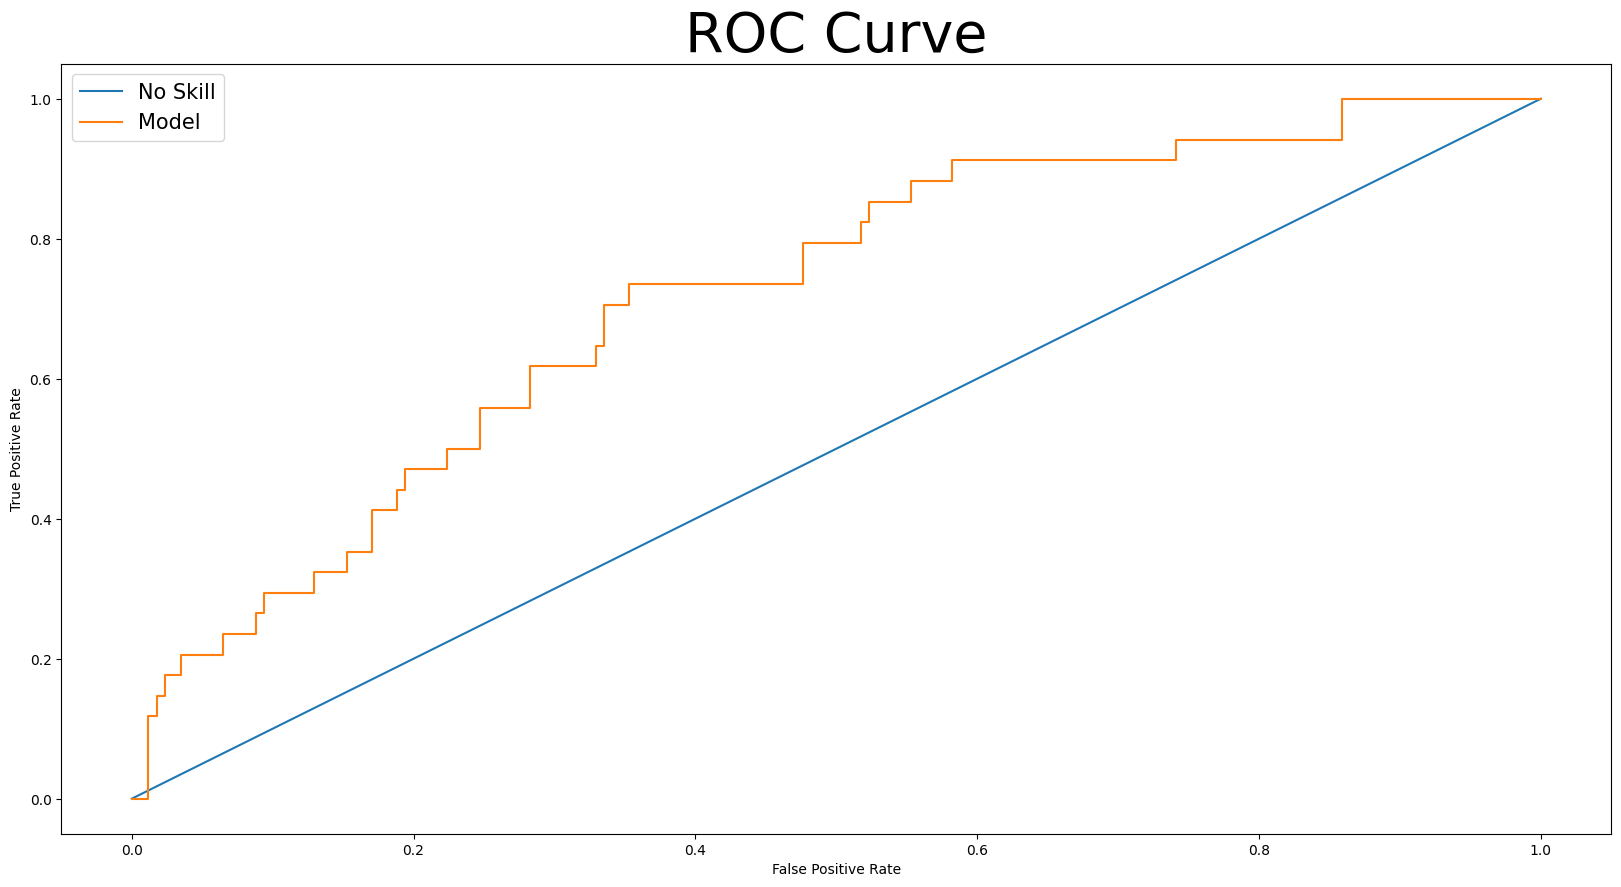

In [27]:

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, predict)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Model: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, predict)
plt.figure(figsize = (20,10))
plt.title("ROC Curve",fontsize = 40)
plt.plot(ns_fpr, ns_tpr,label='No Skill')
plt.plot(lr_fpr, lr_tpr, label='Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.rcParams["font.size"] = "15"

plt.legend()
plt.show()

In [28]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names ):

    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [31]:
from tensorflow import keras
img_array=x_test[0,:,:,:]

img_array=np.reshape(img_array,(1,256,256,1))
preds = model.predict(img_array)
last_conv_layer_name = "top_conv"
classifier_layer_names = ["flatten"]

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)
img = keras.preprocessing.image.img_to_array(x_test[0,:,:,:])
import matplotlib.cm as cm
# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)
# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")
# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
# Superimpose the heatmap on original image
img2=np.zeros([256,256,3])
img2[:,:,0]=img[:,:,0]
superimposed_img = jet_heatmap * 0.0025 + img2
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
superimposed_img=np.uint8(superimposed_img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-31-fd6d80817aea>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


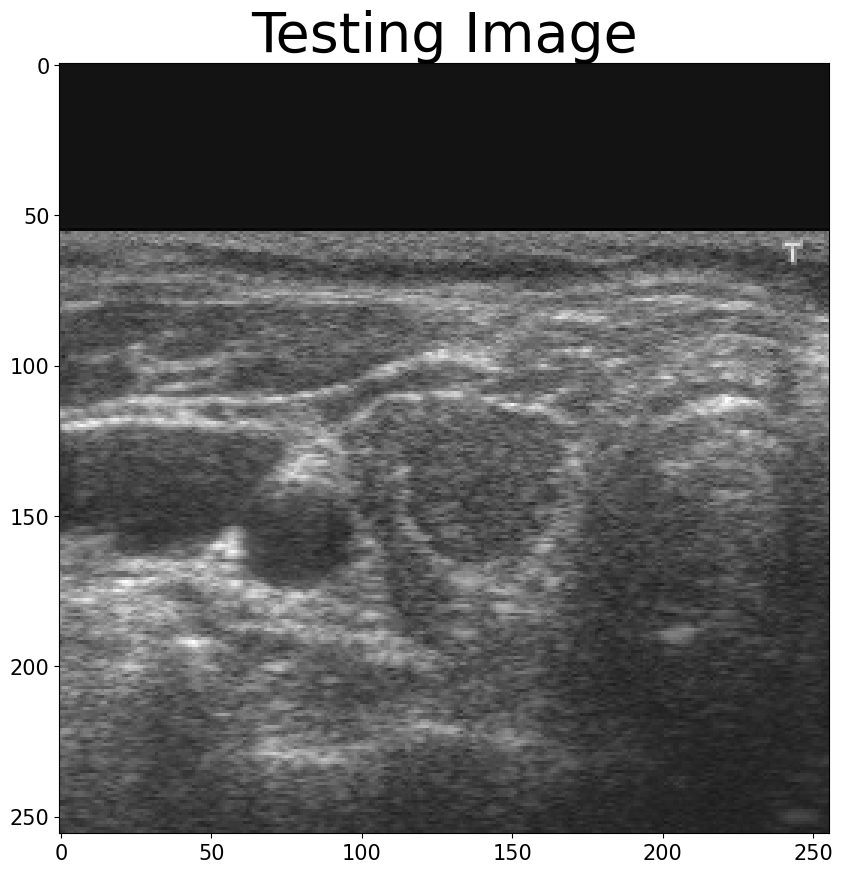

In [32]:
plt.figure(figsize = (20,10))
plt.title("Testing Image",fontsize = 40)
plt.imshow(img_array[0,:,:,:],cmap="gray")

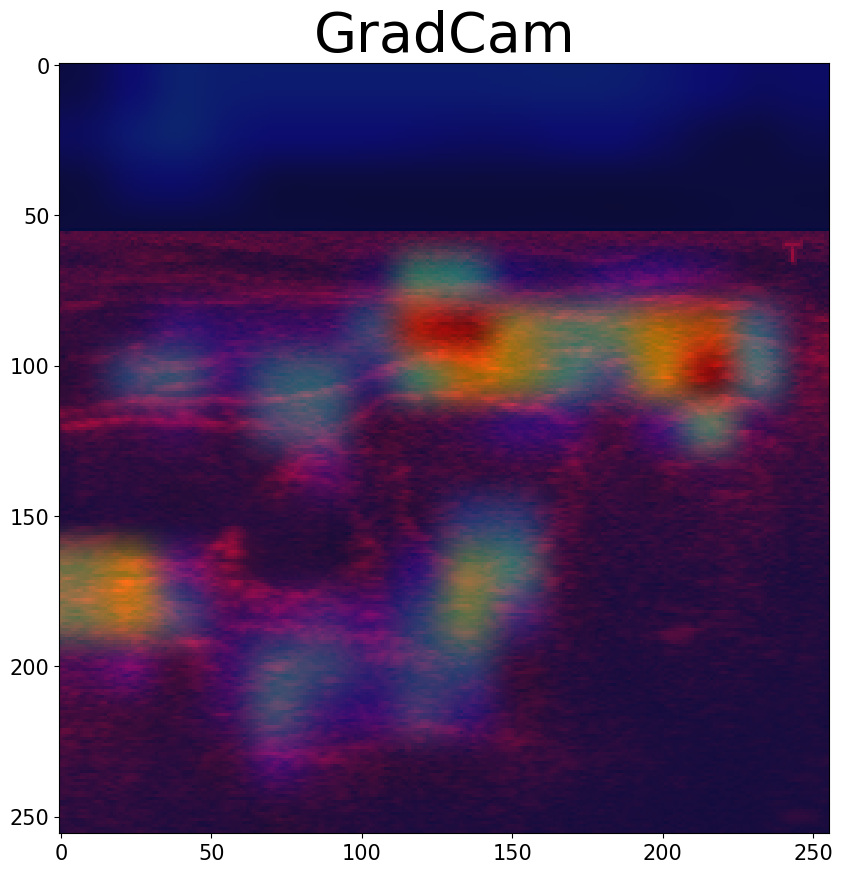

In [33]:
plt.figure(figsize = (20,10))
plt.title("GradCam",fontsize = 40)
plt.imshow(superimposed_img)